In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import gc

# this line forces theano to use the GPU and should go before importing cell2location
#os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=float32,force_device=True'
# if using the CPU uncomment this:
os.environ["THEANO_FLAGS"] = 'device=cpu,floatX=float32,openmp=True,force_device=True'

import cell2location

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

# silence scanpy that prints a lot of warnings
import warnings



import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs
import pandas as pd 
from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel


/home/sclab/miniconda3/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


In [2]:
def convert_celltype_name_into_array(sp_cluster,sp_ct_name):
    annotation_spatial_barcode_id= sp_cluster[:,0]
    annotation_spatial_cluster_id= sp_cluster[:,1]
    spatialcell_unique_clustername=sp_ct_name[:,1]
    spatialcell_unique_clusterid=sp_ct_name[:,0]
    d={}
    for i in range(len(sp_ct_name)):
        d[sp_ct_name[i,0]]=sp_ct_name[i,1]
    annotation_spatial_celltypename=[]
    for i in range(len(annotation_spatial_cluster_id)):
        #print(i,annotation_spatial_cluster_id[i],type(annotation_spatial_cluster_id[i]))
        annotation_spatial_celltypename.append(d[annotation_spatial_cluster_id[i]])
    annotation_spatial_celltypename=np.array(annotation_spatial_celltypename)
    
    return annotation_spatial_celltypename


In [3]:
'''
# Set paths to data and results used through the document:
sp_data_folder = './data/mouse_brain_visium_wo_cloupe_data/'
results_folder = './results/embryo_cell2location/'

regression_model_output = 'RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes'
reg_path = f'{results_folder}regression_model/{regression_model_output}/'

# Download and unzip spatial data
if os.path.exists('./data') is not True:
    os.mkdir('./data')
    os.system('cd ./data && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_visium_wo_cloupe_data.zip')
    os.system('cd ./data && unzip mouse_brain_visium_wo_cloupe_data.zip')

# Download and unzip snRNA-seq data with signatures of reference cell types
# (if the output folder was not created by tutorial 1/3)
if os.path.exists(reg_path) is not True:
    os.mkdir('./results')
    os.mkdir(f'{results_folder}')
    os.mkdir(f'{results_folder}regression_model')
    os.mkdir(f'{reg_path}')
    os.system(f'cd {reg_path} && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_snrna/regression_model/RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes/sc.h5ad')
'''

"\n# Set paths to data and results used through the document:\nsp_data_folder = './data/mouse_brain_visium_wo_cloupe_data/'\nresults_folder = './results/embryo_cell2location/'\n\nregression_model_output = 'RegressionGeneBackgroundCoverageTorch_65covariates_40532cells_12819genes'\nreg_path = f'{results_folder}regression_model/{regression_model_output}/'\n\n# Download and unzip spatial data\nif os.path.exists('./data') is not True:\n    os.mkdir('./data')\n    os.system('cd ./data && wget https://cell2location.cog.sanger.ac.uk/tutorial/mouse_brain_visium_wo_cloupe_data.zip')\n    os.system('cd ./data && unzip mouse_brain_visium_wo_cloupe_data.zip')\n\n# Download and unzip snRNA-seq data with signatures of reference cell types\n# (if the output folder was not created by tutorial 1/3)\nif os.path.exists(reg_path) is not True:\n    os.mkdir('./results')\n    os.mkdir(f'{results_folder}')\n    os.mkdir(f'{results_folder}regression_model')\n    os.mkdir(f'{reg_path}')\n    os.system(f'cd {reg

In [3]:
results_folder = './results/liver_cell2location/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures/'
run_name = f'{results_folder}/cell2location_map'

reg_path=ref_run_name

In [4]:
scdatapath='./inputSC/'
spdatapath='./inputSP/'

spa_data = sc.read_h5ad(spdatapath+'common_counts_sp.h5ad')
seq_data = sc.read_h5ad(scdatapath+'Original_counts.h5ad')

In [5]:
#default parameter 
cell_count_cutoff=5, 
cell_percentage_cutoff2=0.03, 
nonz_mean_cutoff=1.12

In [6]:
spa_data.uns.keys()

odict_keys([])

In [7]:
spa_data.obs['domain_id']=0
#spa_data.obs['domain_id']=seq_data.obs['domain_id'].astype('category')


In [8]:
#name=scdatapath+'cluster_.csv'
name=scdatapath+'/scdata2_most_recent/cluster_25.csv'
df=pd.read_csv(name)
sc_cluster=df.to_numpy()

#celltypefname=scdatapath+'nameOfCT_SI_cellstate.dat'
celltypefname=scdatapath+'scdata2_most_recent/nameOfCT_25.dat'
df=pd.read_csv(celltypefname,sep='\t',header=None)
sc_CTname=df.to_numpy()


In [9]:
cluSC=convert_celltype_name_into_array(sc_cluster,sc_CTname)
seq_data.obs['cell_type']=cluSC
seq_data.obs['domain_id']=0
seq_data.obs['domain_id']=seq_data.obs['domain_id'].astype('category')
seq_data.obs['Method']='RNA'
#seq_data.obs['labels']=sc_cluster[:,1

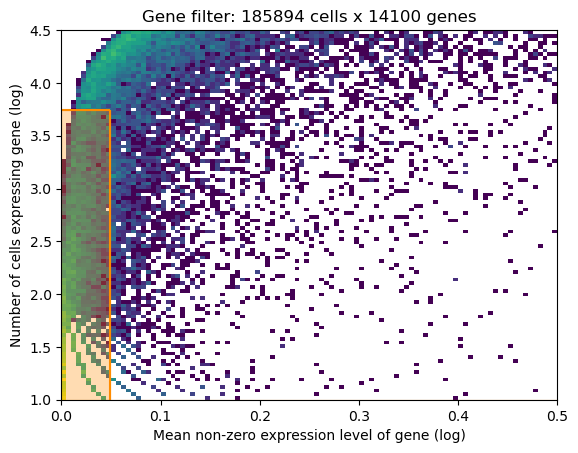

AnnData object with n_obs × n_vars = 185894 × 14100
    obs: 'n_counts', 'n_genes', 'cell_type', 'domain_id', 'Method'
    var: 'n_cells', 'nonz_mean'


In [10]:
selected = filter_genes(seq_data, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = seq_data[:, selected].copy()

print(adata_ref)

In [11]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='domain_id',
                        # cell type, covariate used for constructing signatures
                        labels_key='cell_type',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [12]:
# create the regression model
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.1.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'domain_id',
│   'labels_key': 'cell_type',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 185894 │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   25   │
│          n_vars          │ 14100  │
└──────────────────────────┴────────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['domain_id'] │     0      │          0          │
└────────────────────────┴────────────┴─────────────────────┘

                      labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │     B cells     │          0          │
│                        │    Basophils    │          1          │
│                        │ Central Vein EC │          2          │
│                        │ Cholangiocytes  │          3          │
│                        │   Fibroblast    │          4          │
│                        │    Hep145_P     │          5          │
│                        │     Hep2_MP     │          6          │
│                        │    Hep378_MC    │          7          │
│                        │     Hep6_C      │          8          │
│                        │      HsPCs      │          9          │
│                        │      ILC1s      │         10          │
│                        │       KCs       │         11          │
│                        │      LSECs      │         12          │
│                        │  Lymphatic EC   │         13          │
│                        │      Macro      │         14          │
│                        │    Mig. cDCs    │         15          │
│                        │    Monocytes    │         16          │
│                        │    NK cells     │         17          │
│                        │   Neutrophils   │         18          │
│                        │ Portain Vein EC │         19          │
│                        │ Stellate cells  │         20          │
│                        │     T cells     │         21          │
│                        │      cDC1s      │         22          │
│                        │      cDC2s      │         23          │
│                        │      pDCs       │         24          │
└────────────────────────┴─────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    RNA     │          0          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [17]:
mod.train(max_epochs=250)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/agrawal/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Epoch 250/250: 100%|████████████████████████████████████████████████████████████████████████████████████| 250/250 [14:02:33<00:00, 164.85s/it, v_num=1, elbo_train=1.18e+9]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|████████████████████████████████████████████████████████████████████████████████████| 250/250 [14:02:33<00:00, 202.22s/it, v_num=1, elbo_train=1.18e+9]


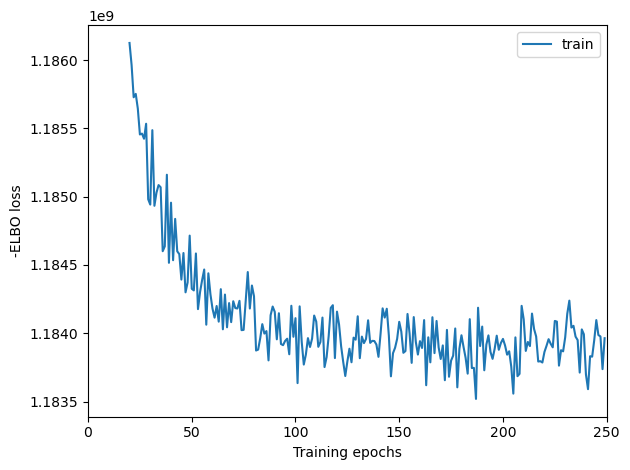

In [18]:
mod.plot_history(20)


In [13]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

Sampling global variables, sample:   6%|▍      | 64/999 [00:09<02:18,  6.77it/s]


KeyboardInterrupt: 

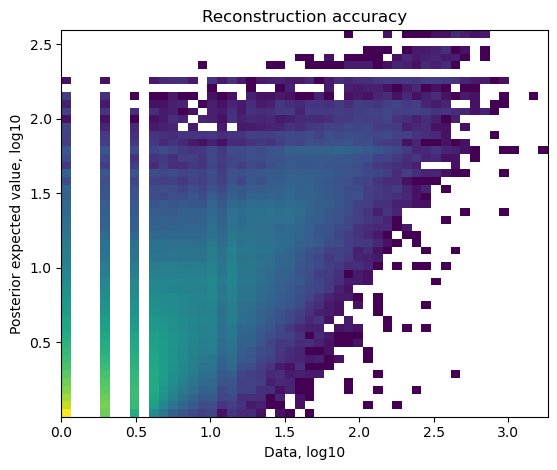

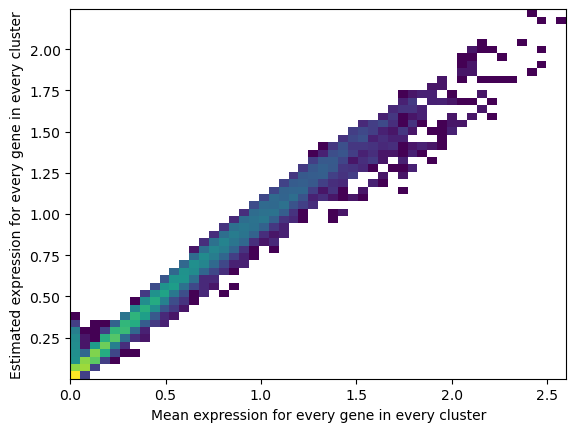

In [20]:
mod.plot_QC()


In [14]:
#The model and output h5ad can be loaded later like this:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./results/liver_cell2location//reference_signatures/model.pt already downloaded                      


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sclab/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Epoch 1/108:   1%| | 1/108 [00:01<02:07,  1.19s/it, v_num=1, elbo_train=1.27e+9]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/108:   1%| | 1/108 [00:01<02:07,  1.19s/it, v_num=1, elbo_train=1.27e+9]


In [15]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B cells,Basophils,Central Vein EC,Cholangiocytes,Fibroblast
Xkr4,0.000382,0.008271,0.001427,0.111350,1.078542
Sox17,0.001995,0.013529,0.647034,0.020868,0.013642
Mrpl15,0.168065,0.175101,0.427363,0.794607,0.244199
Lypla1,0.158075,0.104769,0.474778,0.435393,0.136355
Gm37988,0.000954,0.008691,0.004422,0.012410,0.023038


#spatial mapping 


In [16]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(spa_data.var_names, inf_aver.index)
adata_vis = spa_data[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="domain_id")

In [ ]:
N_cells_per_location=1
detection_alpha=20
detection_alpha=200

In [17]:
# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=1,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.20.1.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'domain_id',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   1    │
│         n_cells          │ 391678 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  310   │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                    batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['domain_id'] │     0      │          0          │
└────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/sclab/miniconda3/envs/scvi-env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")


Epoch 30000/30000: 100%|█| 30000/30000 [43:14:58<00:00,  5.23s/it, v_num=1, elbo

`Trainer.fit` stopped: `max_epochs=30000` reached.


Epoch 30000/30000: 100%|█| 30000/30000 [43:14:58<00:00,  5.19s/it, v_num=1, elbo


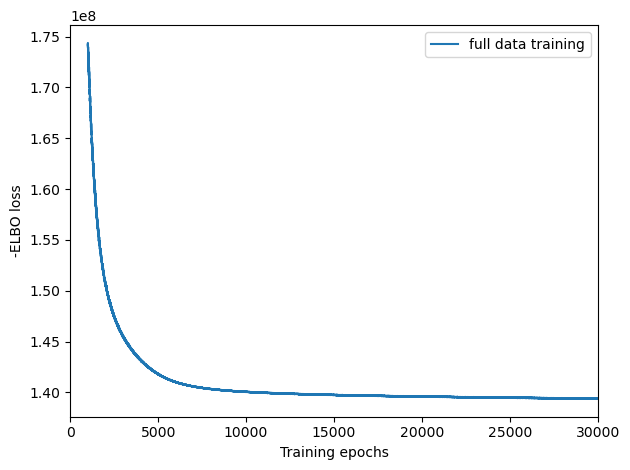

In [18]:
mod.train(max_epochs=30000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          log_every_n_steps=1,
         )

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);

In [19]:
adata_vis = mod.export_posterior(
    adata_vis, use_quantiles=True,
    add_to_obsm=["q05","q50", "q95", "q0001"],
    sample_kwargs={'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file


'./results/liver_cell2location//cell2location_map/sp.h5ad'

In [ ]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
'''
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': False}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = f"{run_name}/sp.h5ad"
adata_vis.write(adata_file)
adata_file
'''

Sampling local variables, batch:   0%|                                              | 0/1 [00:00<?, ?it/s]

In [27]:
# prepare anndata for the regression model
'''
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                        labels_key='Subset',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        categorical_covariate_keys=['Method']
                       )
 '''                      

"\ncell2location.models.RegressionModel.setup_anndata(adata=adata_ref,\n                        # 10X reaction / sample / batch\n                        batch_key='Sample',\n                        # cell type, covariate used for constructing signatures\n                        labels_key='Subset',\n                        # multiplicative technical effects (platform, 3' vs 5', donor effect)\n                        categorical_covariate_keys=['Method']\n                       )\n "

In [9]:


# Read data
ref = sc.read(
    f'./data/sc.h5ad',
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
)

  0%|          | 0.00/527M [00:00<?, ?B/s]

In [30]:
#ref

In [16]:
len(np.unique(ref.obs['Method']))

2

In [15]:
len(np.unique(ref.obs['Sample']))


23

In [17]:
len(np.unique(ref.obs['Subset']))


34